<a href="https://colab.research.google.com/github/andersonjhones/Transferlearning/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferência de aprendizagem 

## Transferência de aprendizagem

### Importação das bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
tf.__version__

'2.8.2'

### Carregamento das imagens

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Descompactando as imagens**

In [3]:
path = '/content/drive/MyDrive/visaocomputacional/cat_dog_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

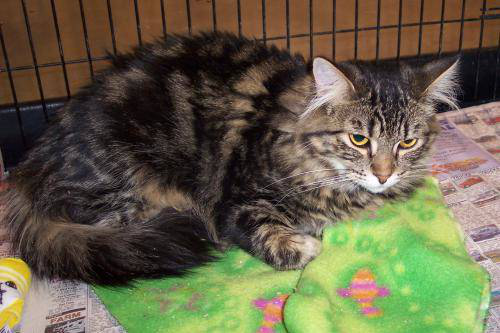

In [ ]:
tf.keras.preprocessing.image.load_img('/content/cat_dog_2/training_set/cat/cat.1005.jpg')

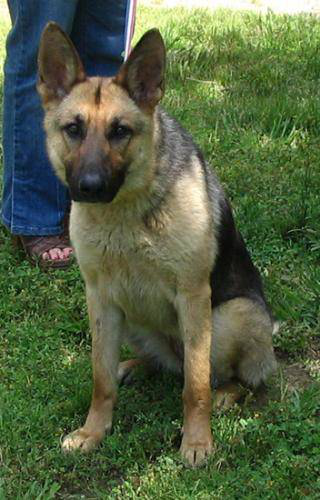

In [ ]:
tf.keras.preprocessing.image.load_img('/content/cat_dog_2/training_set/dog/dog.1015.jpg')

### Base de dados de treinamento e teste

**Normalizando a base de dados e colocando para o tamanho adequado para a rede MobileNetV2.**

In [8]:
gerador_treinamento = ImageDataGenerator(rescale=1./255,)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/cat_dog_2/training_set',
                                                        target_size = (224, 224),
                                                        batch_size = 224,
                                                        class_mode = 'binary',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


In [9]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/cat_dog_2/test_set',
                                                     target_size = (224, 224),
                                                     batch_size = 1,
                                                     class_mode = 'binary',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


### Rede neural pré-treinada

In [10]:
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


**Sumário do modelo**

In [11]:
modelo_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**Número de camadas da rede neural**

In [12]:
len(modelo_base.layers)

154

In [13]:
for layer in modelo_base.layers:
  layer.trainable = False

### Camada densa personalizada

In [14]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(1, activation = 'sigmoid')(head_model)

### Construção e treinamento da rede neural

In [15]:
network = Model(inputs = modelo_base.input, outputs = head_model)

In [16]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

**Compilação da rede visando a melhor acurácia, otimizador Adam e o parâmtro de perdas com crossentropia binária.**

In [17]:
network.compile(loss = 'binary_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

**Treinamento da rede com 10 épocas**

In [18]:
historico = network.fit(dataset_treinamento, epochs=10)

Epoch 1/10
18/18 [==============================] - 28s 729ms/step - loss: 0.1625 - accuracy: 0.9168
Epoch 2/10
18/18 [==============================] - 13s 698ms/step - loss: 0.0410 - accuracy: 0.9855
Epoch 3/10
18/18 [==============================] - 13s 700ms/step - loss: 0.0266 - accuracy: 0.9915
Epoch 4/10
18/18 [==============================] - 13s 697ms/step - loss: 0.0179 - accuracy: 0.9927
Epoch 5/10
18/18 [==============================] - 13s 702ms/step - loss: 0.0135 - accuracy: 0.9948
Epoch 6/10
18/18 [==============================] - 13s 692ms/step - loss: 0.0061 - accuracy: 0.9985
Epoch 7/10
18/18 [==============================] - 13s 698ms/step - loss: 0.0038 - accuracy: 0.9990
Epoch 8/10
18/18 [==============================] - 13s 703ms/step - loss: 0.0022 - accuracy: 0.9995
Epoch 9/10
18/18 [==============================] - 13s 705ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 10/10
18/18 [==============================] - 13s 704ms/step - loss: 7.5260e-04 - ac

**Avaliação do modelo nos dados de teste.**

In [19]:

network.evaluate(dataset_teste)

1000/1000 [==============================] - 11s 10ms/step - loss: 0.1035 - accuracy: 0.9790


[0.10354278236627579, 0.9789999723434448]

### Avaliação da rede neural com a predição das imagens de teste, mostrando a acurácia, a matriz de confusão e o relatório de classificaçãocom métricas como o F1-score, Precision e Recall

In [20]:
predict=network.predict(dataset_teste)

In [21]:
previsao=[]

In [22]:
for i in predict:
  if i <0.5:
    previsao.append(0)
  else:
    previsao.append(1)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,  classification_report, ConfusionMatrixDisplay

In [24]:
accuracy_score(dataset_teste.classes, previsao)

0.979

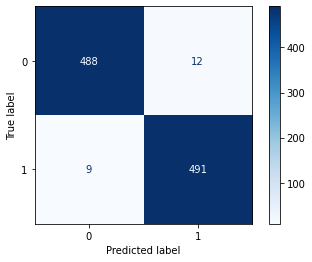

In [25]:
ConfusionMatrixDisplay.from_predictions(dataset_teste.classes, previsao, cmap='Blues');
plt.grid(False)

In [26]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(dataset_teste.classes, previsao))

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



###**Rede Neural Pré-treinada Xception**

In [ ]:
gerador_treinamento = ImageDataGenerator(rescale=1./255,)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/cat_dog_2/training_set',
                                                        target_size = (299, 299),
                                                        batch_size = 299,
                                                        class_mode = 'binary',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/cat_dog_2/test_set',
                                                     target_size = (299, 299),
                                                     batch_size = 1,
                                                     class_mode = 'binary',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


In [ ]:
modelo_base = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                               input_shape = (299, 299, 3))

83697664/83683744 [==============================] - 0s 0us/step


**Sumário do modelo**

In [ ]:
modelo_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

**Número de camadas**

In [ ]:
len(modelo_base.layers)

132

In [ ]:
for layer in modelo_base.layers:
  layer.trainable = False

**Aplicando camadas densas no modelo.**

In [ ]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(1025, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(1025, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(1, activation = 'sigmoid')(head_model)

In [ ]:
network = Model(inputs = modelo_base.input, outputs = head_model)

In [ ]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
network.compile(loss = 'binary_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [ ]:
historico = network.fit(dataset_treinamento, epochs=5)

Epoch 1/5
14/14 [==============================] - 46s 2s/step - loss: 0.1280 - accuracy: 0.9350
Epoch 2/5
14/14 [==============================] - 31s 2s/step - loss: 0.0241 - accuracy: 0.9935
Epoch 3/5
14/14 [==============================] - 32s 2s/step - loss: 0.0087 - accuracy: 0.9975
Epoch 4/5
14/14 [==============================] - 32s 2s/step - loss: 0.0096 - accuracy: 0.9975
Epoch 5/5
14/14 [==============================] - 33s 2s/step - loss: 0.0026 - accuracy: 0.9995


In [ ]:

network.evaluate(dataset_teste)

1000/1000 [==============================] - 14s 13ms/step - loss: 0.0340 - accuracy: 0.9910


[0.03402433916926384, 0.9909999966621399]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,  classification_report, ConfusionMatrixDisplay

In [ ]:
predict=network.predict(dataset_teste)

In [ ]:
previsao=[]

In [ ]:
for i in predict:
  if i <0.5:
    previsao.append(0)
  else:
    previsao.append(1)

In [ ]:
accuracy_score(dataset_teste.classes, previsao)

0.991

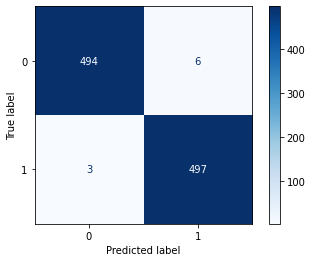

In [ ]:
ConfusionMatrixDisplay.from_predictions(dataset_teste.classes, previsao, cmap='Blues');
plt.grid(False)

In [ ]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(dataset_teste.classes, previsao))

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

